In [1]:
from collections import defaultdict, Counter, OrderedDict
import numpy as np
from copy import copy
from itertools import groupby, permutations, product
import json
import matplotlib.pyplot as plt
import numpy as np

# DATA

In [125]:
test = """FF7FSF7F7F7F7F7F---7
L|LJ||||||||||||F--J
FL-7LJLJ||||||LJL-77
F--JF--7||LJLJIF7FJ-
L---JF-JLJIIIIFJLJJ7
|F|F-JF---7IIIL7L|7|
|FFJF7L7F-JF7IIL---7
7-L-JL7||F7|L7F-7F7|
L.L7LFJ|||||FJL7||LJ
L7JLJL-JLJLJL--JLJ.L
"""
test_f = test.splitlines()
test_f = [[c for c in l] for l in test_f]
test_f = np.array(test_f)

In [126]:
f = open("inputs/aoc10.txt")
f = f.read().splitlines()
f = [[c for c in l] for l in f]
f = np.array(f)

In [3]:
def get_coor_S(f):
    for i,line in enumerate(f):
        for j,c in enumerate(line):
            if c=="S":
                return i,j
    

In [4]:
get_coor_S(f)

(76, 24)

In [6]:
def add_coord(current_coord, rel_change):
    return current_coord[0]+rel_change[0], current_coord[1]+rel_change[1]

In [7]:
def invert_coord(coord):
    return -1*coord[0], -1*coord[1]

In [8]:
def connected_coords(current_coord):
    
    # valid chars per relative position frpm current coord
    valid_chars = {}
    valid_chars["L"] = [[],["|","F","7"],["-","7","J"],[]]
    valid_chars["J"] = [["-","F","L"],["|","F","7"],[],[]]
    valid_chars["7"] = [["-","F","L"],[],[],["|","L","J"]]
    valid_chars["F"] = [[],[],["-","J","7"],["|","J","L"]]
    valid_chars["|"] = [[],["|","F","7"],[],["|","L","J"]]
    valid_chars["-"] = [["-","F","L"],[],["-","J","7"],[]]
    
    current_symbol=f[current_coord]
    valids = valid_chars[current_symbol]
    rel_pos = [[0,-1],[-1,0],[0,1],[1,0]]
    
    new_coords = []
    for i,change in enumerate(rel_pos):
        new_coord = add_coord(current_coord, change)
        try:
            new_symbol = f[new_coord]
        except:
            pass
        if new_symbol in valids[i]:
            new_coords.append(new_coord)
    return new_coords

In [9]:
def compute_chain(f,start_coord1):
    
    S=get_coor_S(f)
    loop_coords=[]
    loop_coords.append(S)

    # next
    loop_coords.append(start_coord1)
    new_coord = start_coord1
    limit = f.shape[0]*f.shape[1]
    iter=0
    while new_coord != S:
        iter=iter+1
        previous_coord = loop_coords[-2]
        new_coords = connected_coords(new_coord)

        for nc in new_coords:
            if nc!=previous_coord:
                new_coord=copy(nc)
                loop_coords.append(new_coord)  
        #print('prev:', previous_coord,'newcoords',new_coords,  "new coord:", new_coord, "chain", loop_coords)
        if iter>limit:
            break
    return loop_coords

In [14]:
len(compute_chain(f,start_coord1=(76,23)))/2

6842.0

# 2

In [31]:
# proceed along pipe, check next tile, check state of tile to the orthogonal right
# if ground, add to list of I -> list of seeds from which to explore more
# for each tile in I:
# recurvively scan surraoundings for ground tiles,until no new tiles get added

In [15]:
def get_direction(n1, n2):
    return (n2[0]-n1[0],n2[1]-n1[1])

In [16]:
def rotate(coord):
    return (-coord[1],coord[0])

In [82]:
def not_part_of_loop(seed_coord, loop_coords,f=f):
    
    # check the 4 coordinates around seed_coord
    # if the starting point is inside the loop, these
    # 4 coordinates can only be on the loop or inside
    
    rel_pos = [[0,-1],[-1,0],[0,1],[1,0]]
    new_coords = []
    for i,change in enumerate(rel_pos):
        new_coord = add_coord(seed_coord, change)    
        if (new_coord not in loop_coords) and (coord_in_f(new_coord,f)):
            new_coords.append(new_coord)
    return new_coords        

In [311]:
def more_plot(f,start_coord):
    
    loop_coords = compute_chain(f,start_coord)
    I = make_I(f, start_coord)
    
    g=copy(f)
    for c in I:
        g[c]="I"

    plt.figure(figsize=(35,35))
    plt.imshow(np.where(f=="H",0,1))
    
    for i in I:
        plt.text(i[1],i[0],"I", fontsize=6,color="red")
    for i,c in enumerate(loop_coords):
        plt.text(c[1],c[0],i, fontsize=4,color="white")
    plt.show()

In [297]:
from time import sleep 

In [309]:
def get_nonloop_coordinates(seed_coord, loop_coords):
    # seed coord is the vantage point from where recursively
    # other coordinates are evaluated to be part of the loop or not (in which case they are inside the loop when the seed is within the loop)
    
    coordinates_iterable = [seed_coord]
    all_nonloop_coords = [seed_coord]
    done = False
    i=0
    
    while not done:
        i=i+1
        print("---------------------------")
        print(i,coordinates_iterable)
        
        
        for non_loop_coord in coordinates_iterable:
            # accumulating all newly spawned coordinates
            new_non_loop_coords = not_part_of_loop(non_loop_coord, loop_coords,f)
            net_new = set(new_non_loop_coords) - set(all_nonloop_coords)
            all_nonloop_coords.extend(net_new)
               
        # loop again over all non-loop coordinates found so far
        if len(net_new)==0:
            done = True               
        
        print(i,len(all_nonloop_coords), len(net_new))
              
        coordinates_iterable = all_nonloop_coords
    
    return all_nonloop_coords

In [310]:
get_nonloop_coordinates((70,70), loop_coords)

---------------------------
1 [(70, 70)]
1 5 4
---------------------------
2 [(70, 70), (70, 71), (71, 70), (69, 70), (70, 69)]
2 251 0


[(70, 70),
 (70, 71),
 (71, 70),
 (69, 70),
 (70, 69),
 (70, 72),
 (71, 71),
 (69, 71),
 (71, 69),
 (72, 70),
 (68, 70),
 (69, 69),
 (70, 68),
 (69, 72),
 (70, 73),
 (71, 72),
 (72, 71),
 (68, 71),
 (71, 68),
 (72, 69),
 (73, 70),
 (68, 69),
 (67, 70),
 (69, 68),
 (70, 67),
 (69, 73),
 (68, 72),
 (71, 73),
 (70, 74),
 (72, 72),
 (73, 71),
 (67, 71),
 (72, 68),
 (71, 67),
 (73, 69),
 (74, 70),
 (67, 69),
 (68, 68),
 (66, 70),
 (69, 67),
 (70, 66),
 (69, 74),
 (68, 73),
 (67, 72),
 (72, 73),
 (71, 74),
 (74, 71),
 (66, 71),
 (72, 67),
 (73, 68),
 (71, 66),
 (74, 69),
 (66, 69),
 (67, 68),
 (68, 67),
 (65, 70),
 (69, 66),
 (70, 65),
 (68, 74),
 (67, 73),
 (66, 72),
 (72, 74),
 (71, 75),
 (65, 71),
 (73, 67),
 (72, 66),
 (74, 68),
 (71, 65),
 (75, 69),
 (66, 68),
 (65, 69),
 (67, 67),
 (68, 66),
 (64, 70),
 (69, 65),
 (70, 64),
 (67, 74),
 (66, 73),
 (65, 72),
 (72, 75),
 (71, 76),
 (64, 71),
 (73, 66),
 (74, 67),
 (72, 65),
 (75, 68),
 (71, 64),
 (76, 69),
 (66, 67),
 (65, 68),
 (64, 69),

In [281]:
def coord_in_f(coord,f=f):
    try:
        return (coord[0]>=0) and (coord[0]<f.shape[0]) and (coord[1]>=0) and (coord[1]<f.shape[1])
    except:
        return False

In [282]:
def make_I(f, start_coord=(76,23)):

    I = []
    loop_coords = compute_chain(f,start_coord)
    
    # follow the track
    for i,coord in enumerate(loop_coords[:-1]):
        current_coord = loop_coords[i]
        next_coord = loop_coords[i+1]
        direction = get_direction(current_coord, next_coord)
        tile_to_check = add_coord(rotate(direction), current_coord)
        #print(i,current_coord, tile_to_check, f[tile_to_check])

        if (not tile_to_check in loop_coords) and coord_in_f(tile_to_check):
            I.append(tile_to_check)
    
    # fill the regions, from the seeds
    new_I = []
    for c in I:
        new_I.extend(get_nonloop_coordinates(c, loop_coords=loop_coords))
    new_I = list(set(new_I))
    return new_I

In [306]:
I=make_I(f, start_coord=start_coord)

In [307]:
len(I)

385

# ECHIE

In [285]:
f = open("inputs/aoc10.txt")
f = f.read().splitlines()
f = [[c for c in l] for l in f]
f = np.array(f)

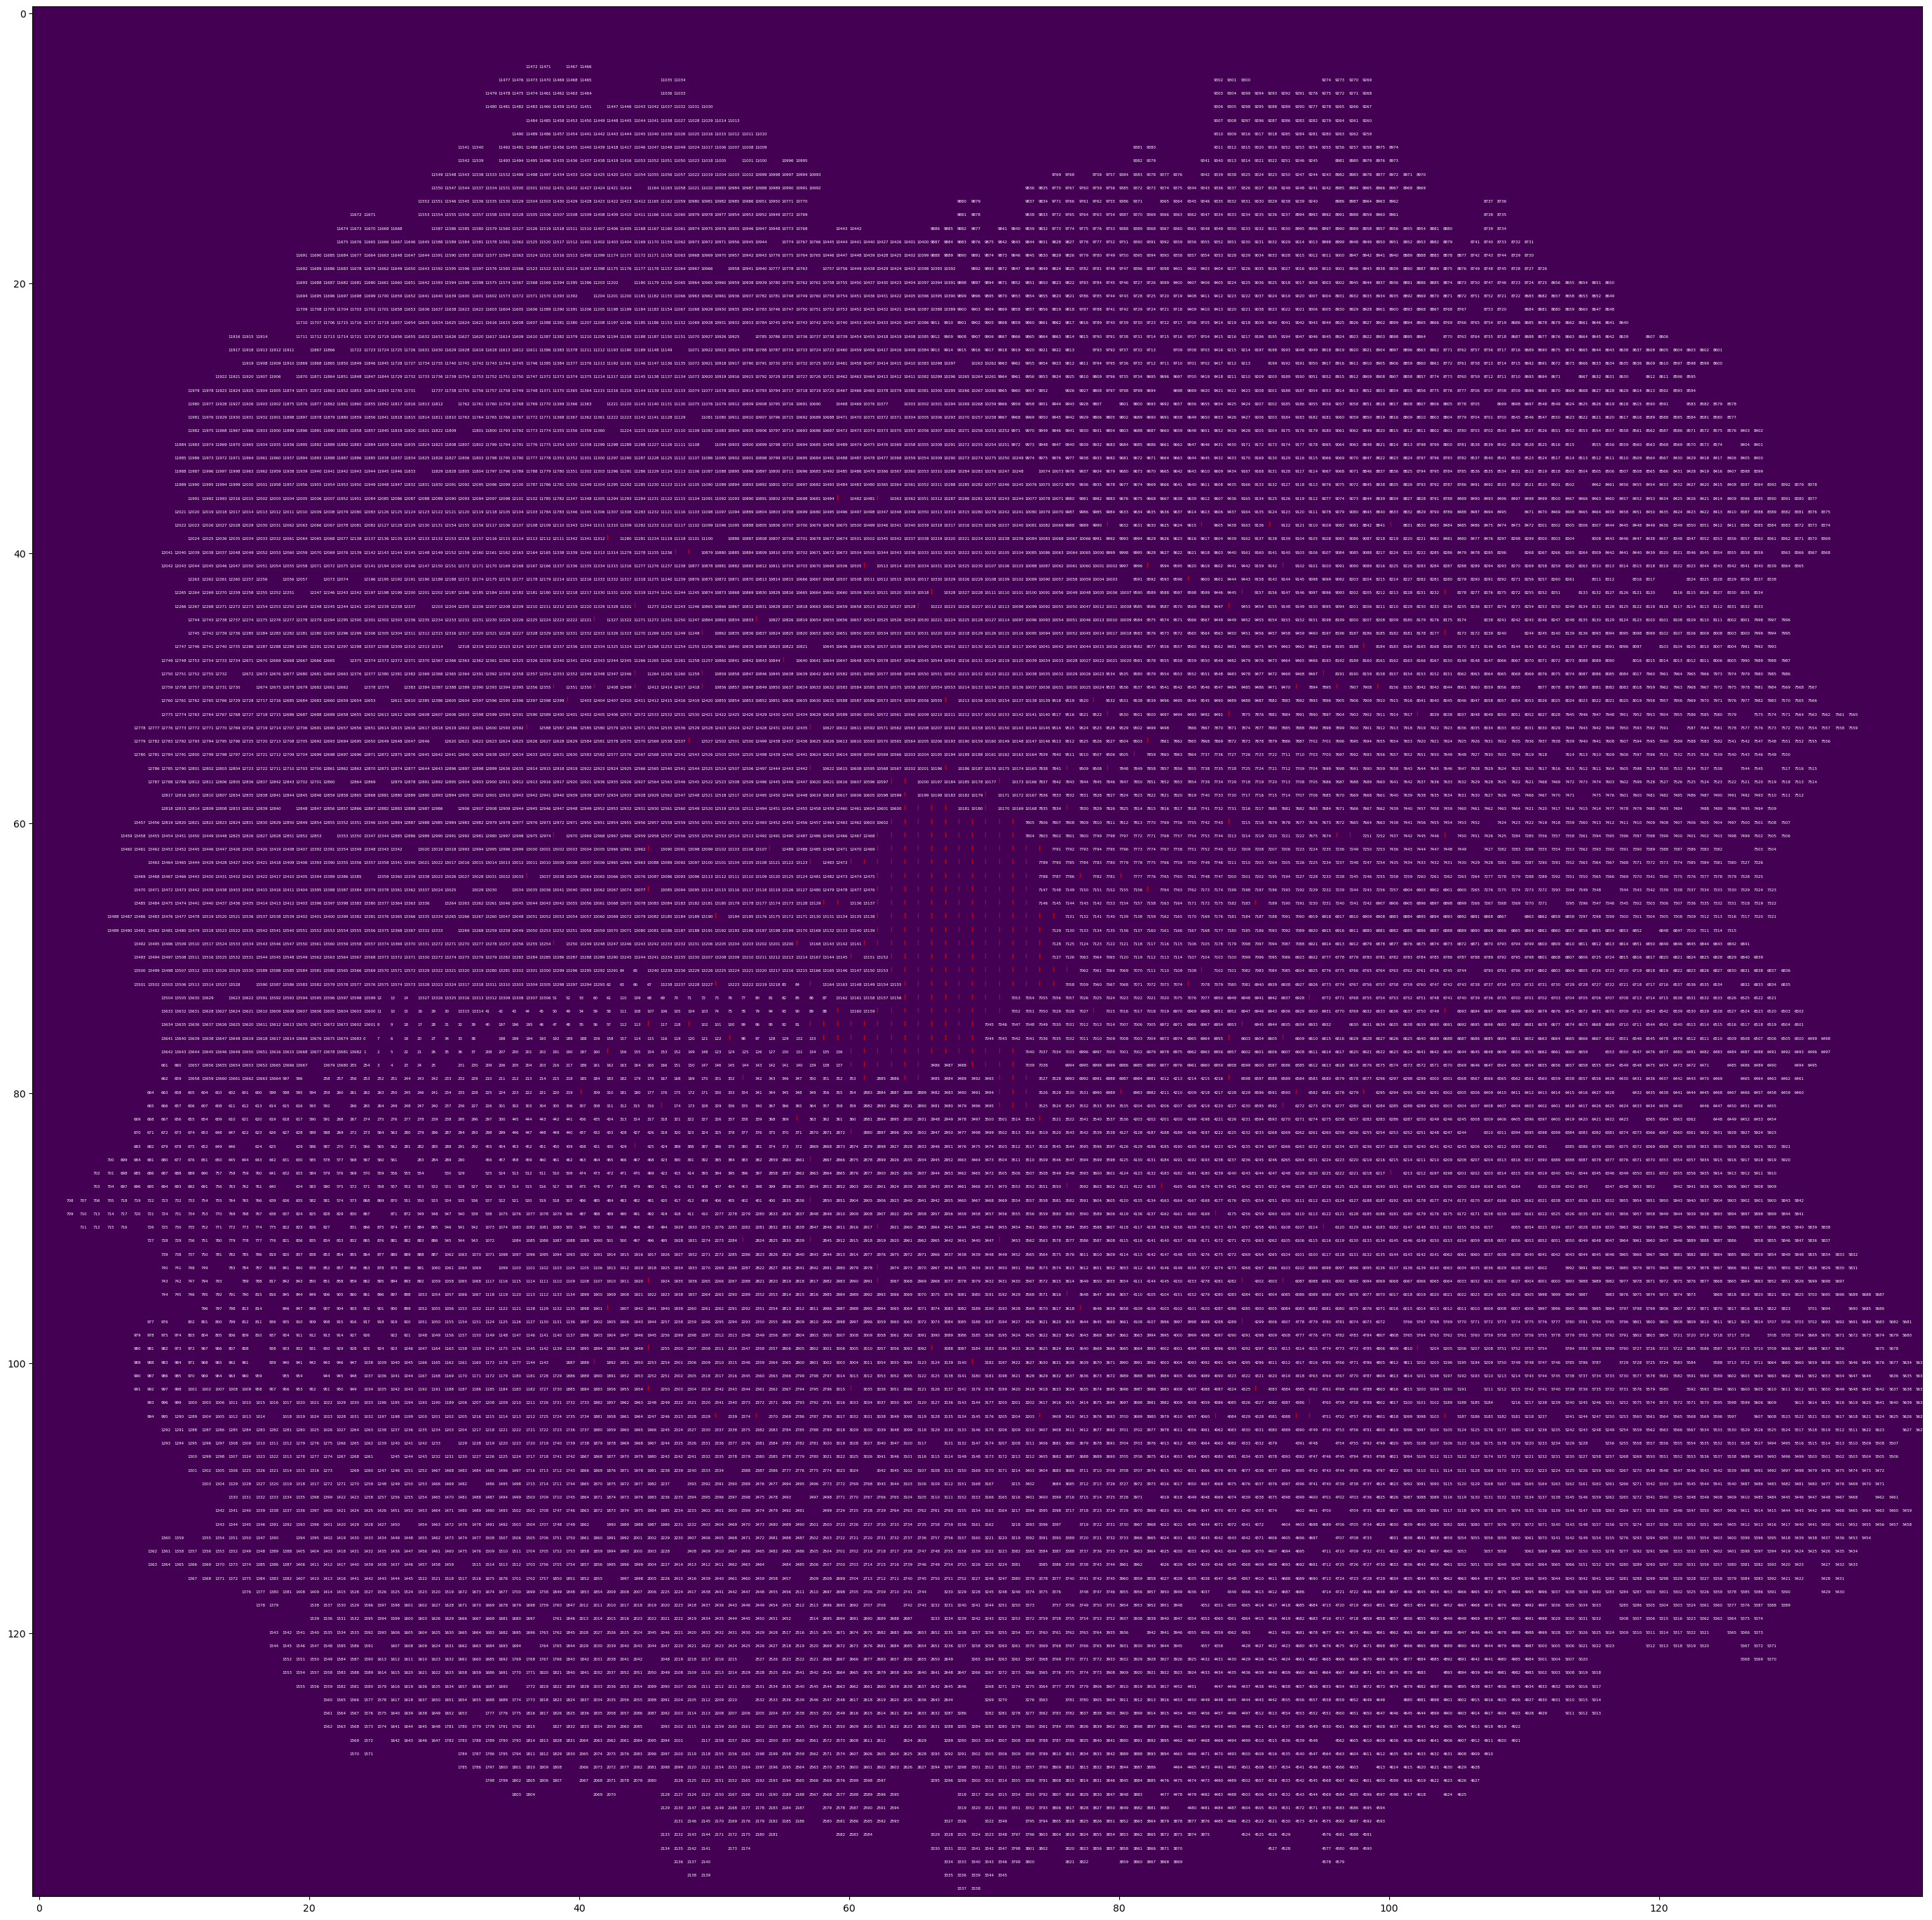

In [312]:
more_plot(f,start_coord=start_coord)